In [1]:
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import KFold as KFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report
from sktime.transformations.panel.rocket import MiniRocketMultivariate as minirocket
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV as LRCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifierCV
from sklearn.dummy import DummyClassifier

In [2]:
# get relative indices
# manually entered via looking at
#https://raw.githubusercontent.com/google/mediapipe/a908d668c730da128dfa8d9f6bd25d519d006692/mediapipe/modules
#/face_geometry/data/canonical_face_model_uv_visualization.png

lower = [76, 77, 90, 180, 85, 16, 315, 404, 320, 307]

upper = [184, 74, 73, 72, 11, 302, 303, 304, 408, 306]

u2 = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409]
l2 = [291, 375, 321, 405, 314, 17, 84, 181, 91, 146]

u3 = [57, 186, 92, 165, 167, 164, 393, 391, 322, 410]
l3 = [287, 273, 335, 406, 313, 18, 83, 182, 106, 43]

combo_indices = lower + upper + u2 + l2 + u3 + l3

In [3]:
opath = "/Users/nraman/Documents/thesis_videos/"
# make sure to get 
subfolders = [i for i in os.listdir(opath) if ".mp4" not in i and ".DS_Store" not in i and ".MOV" not in i]
def find_pointfolder(subfolder, path = "/Users/nraman/Documents/thesis_videos/"):
    cur_path = f"{path}{subfolder}"
    # get names of files within the subfolder
    subfiles = os.listdir(f"{path}{subfolder}")
    nps = [i for i in subfiles if ".npy" in i]
    
    if(len(nps) == 1):
        array = np.load(f"{cur_path}/{nps[0]}")
        array = array[:, combo_indices]
        return(array.reshape(array.shape[0], len(combo_indices)*2))

In [4]:
ground_folders = [i for i in subfolders if "ground" in i]
speak_folders = [i for i in subfolders if "ground" not in i]
bad_ones = []

ground_data = []
speak_data = []

for s in speak_folders:
    data = find_pointfolder(s)
    #if(len(data) < 40):
    if(type(data) == np.ndarray):
        speak_data.append(data)
    else:
        bad_ones.append(s)

s_lengths = [s.shape[0] for s in speak_data]
g_lengths = []

for g in ground_folders:
    ar_init = find_pointfolder(g)
#     num_instances = ar_init.shape[0]
#     g_lengths.append(num_instances)
#     choice = np.random.randint(15, 30)
    
#     if(num_instances > 700):
#         splits = 2
#     else:
#         splits = 1
    
    #ground_data.extend(np.array_split(ar_init, splits))
    if(type(ar_init) == np.ndarray):
        ground_data.append(ar_init)
    else:
        bad_ones.append(g)
        
s_lengths = [s.shape[0] for s in speak_data]
g_lengths = [s.shape[0] for s in ground_data]
maxlen = np.max(s_lengths + g_lengths)

In [5]:
# each input is list of arrays (each 2d, of dimension #timepoints x #points*2)--ground corresponds to no speech
# get dataframe of dimension #samples x #features
def timeseries_df(groundlist, speaklist, num_features = len(combo_indices)*2, const = 0, pd_mode = True):
    sz = len(groundlist) + len(speaklist)
    numspeak = len(speaklist)
    
    if(pd_mode == True):
        df = pd.DataFrame(np.zeros([sz, num_features])).astype(object)
    else:
        df = np.zeros((sz, num_features, maxlen))
    
    for j in range(int(sz)):
        for a in range(len(combo_indices)*2):
            if(j < numspeak):
                cur = speaklist[j][:, a]
            elif (j >= numspeak):
                it = j - numspeak
                cur = groundlist[it][:, a]
            
            if(pd_mode == True):
                df.iloc[j, a] = np.pad(cur, (0, maxlen - len(cur)), constant_values = (const))
            else:
                df[a, j] = np.pad(cur, (0, maxlen - len(cur)), constant_values = (const))
    
    true = np.concatenate([np.ones(numspeak), np.zeros(sz - numspeak)])
    
    return df, true

In [6]:
alldata, alltrue = timeseries_df(ground_data, speak_data)

In [20]:
kf = KFold(n_splits=5, shuffle = True)
kf.get_n_splits(X = alldata, y = alltrue)

preds = []
actual = []

for train_index, test_index in tqdm(kf.split(alldata, alltrue)):
    X_train, X_test = alldata.iloc[train_index,:], alldata.iloc[test_index,:]
    y_train, y_test = alltrue[train_index], alltrue[test_index]
    
    rocket = minirocket()
    rocket.fit(X_train)
    X_train_transform = rocket.transform(X_train)
    
    scaler = StandardScaler().fit(X_train_transform)
    
    model = LR(max_iter = 10000, class_weight = {0:1e-2, 1:1})#SVC(C = 1e3)#
    model.fit(scaler.transform(X_train_transform), y_train)
    
    pred_values = model.predict(scaler.transform(rocket.transform(X_test)))
    preds.append([int(i) for i in pred_values])
    actual.append([int(i) for i in y_test])
    print(metrics.confusion_matrix(y_test, pred_values))

1it [00:03,  3.99s/it]

[[38 33]
 [ 3 43]]


2it [00:07,  3.83s/it]

[[39 22]
 [ 3 53]]


3it [00:11,  3.86s/it]

[[31 32]
 [ 0 54]]


4it [00:15,  3.84s/it]

[[38 38]
 [ 1 40]]


5it [00:19,  3.84s/it]

[[41 24]
 [ 4 48]]


In [22]:
allpreds = np.concatenate(preds)
allactual = np.concatenate(actual)

print(classification_report(allactual, allpreds, target_names=["Non-Speech", "Speech"]))

              precision    recall  f1-score   support

  Non-Speech       0.94      0.56      0.70       336
      Speech       0.61      0.96      0.75       249

    accuracy                           0.73       585
   macro avg       0.78      0.76      0.72       585
weighted avg       0.80      0.73      0.72       585



In [23]:
c = metrics.confusion_matrix(allactual, allpreds)
print("Confusion Matrix: " + str(c))
print("False rejection rate: " + str(c[1, 0]/np.sum(c)))

Confusion Matrix: [[187 149]
 [ 11 238]]
False rejection rate: 0.018803418803418803


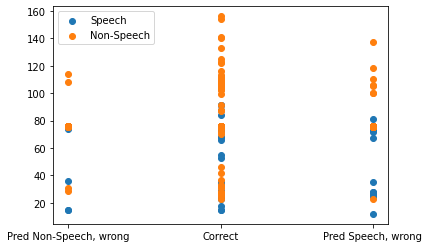

In [10]:
diffs = allpreds-allactual
plt.scatter(diffs[:len(s_lengths)], np.array(s_lengths), label = "Speech")
plt.scatter(diffs[len(s_lengths):], np.array([g.shape[0] for g in ground_data]), label = "Non-Speech")
plt.xticks([-1, 0, 1], labels = ["Pred Non-Speech, wrong", "Correct", "Pred Speech, wrong"])
plt.legend()
plt.show()

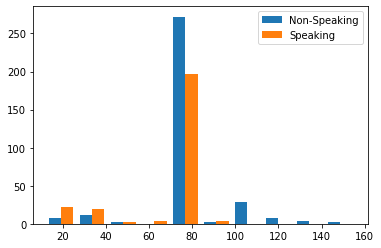

In [11]:
a = [g.shape[0] for g in ground_data]
b = [s.shape[0] for s in speak_data]

plt.hist([a, b], label = ["Non-Speaking", "Speaking"])
plt.legend()
plt.show()

note: when I cap the ground data lengths at 90, accuracy goes down a little bit (overall ~ 80%, FRR close to 10%), and number of false positives roughly equals number of false negatives

In [12]:
testfolders = [i for i in os.listdir("/Users/nraman/Documents/extra_videos/") if ".mp4" not in i 
               and ".DS_Store" not in i and ".MOV" not in i]

In [13]:
test_data = []

for s in testfolders:
    data = find_pointfolder(s, path = "/Users/nraman/Documents/extra_videos/")
    #if(len(data) < 40):
    if(type(data) == np.ndarray):
        test_data.append(data)


In [14]:
df = pd.DataFrame(np.zeros([len(test_data), 120])).astype(object)